<a href="https://colab.research.google.com/github/tidepool-org/data-analytics/blob/ae%2Fpython-daily-visualization/tidepool-daily-visualizations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tidepool Daily Visualizations (Python Version)








## Instructions

1.   Please run this in Playground Mode (click File, and Open in playground mode) or create a copy so you don't overwrite this example (i.e., File, "Save a copy in Drive..."
2.   Before you run the code be sure to select "Connect" in the top right-hand corner of the webpage.
3.   To run the code, you press shift-return to execute each cell, or you can press the Run button (above), or you can click on the 
4.   You will need to enter in your Tidepool credentials to pull your data (i.e., email address & pwd)
5.   You will be prompted to connect your collaboratory instance to google drive, follow the link and copy/paste the auth string back into this notebook.
6.   The code will save the results to your root google drive folder, "My Drive." 

## API Specific

The API code in this notebook is a copy of the original Get Your Tidepool Data Collab Notebook:
https://colab.research.google.com/drive/1Az7nCgc0IoiTS-RSLyhS1gLAlM5Koieg?authuser=2

For the API credentials:

*   You can either enter in the big data credentials (Tidepool employees only) AND userID, or
*   You can enter in your Tidepool email (username) and password (when prompted)

##Required Libraries

In [0]:
# %% REQUIRED LIBRARIES 

#API
import numpy as np
import pandas as pd
import os
import requests
import json
import getpass
#import tz - look at existing code example for this - put in UTC time, automatically
from datetime import timedelta

#Visualizations
import matplotlib.pyplot as plt
import plotly.plotly as py
import datetime
import matplotlib.patches as mpatches
from matplotlib.patches import Ellipse, Circle
from matplotlib import rc
import matplotlib.font_manager

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

# Get and Save Data


In [109]:
# %% get Tidepool data from api
def get_data_from_api(
    email=np.nan,
    password=np.nan,
    years_of_data=10,
    userid_of_shared_user=np.nan,
):
  
    if pd.isnull(email):
        email=input("Enter Tidepool email address:\n")
      
    if pd.isnull(password):
        password=getpass.getpass("Enter password:\n")
  
    df = pd.DataFrame()
    url1 = "https://api.tidepool.org/auth/login"
    url3 = "https://api.tidepool.org/auth/logout"
    
    myResponse = requests.post(url1, auth=(email, password))

    if(myResponse.ok):
        xtoken = myResponse.headers["x-tidepool-session-token"]
        
        if pd.isnull(userid_of_shared_user):
            userid = json.loads(myResponse.content.decode())["userid"]
        else:
            userid = userid_of_shared_user       
        
        endDate = pd.datetime.now()

        for years in range(1, years_of_data + 1):
            startDate = endDate - pd.Timedelta(365, unit="d")

            url2 = "https://api.tidepool.org/data/" + userid + \
                "?endDate=" + endDate.strftime("%Y-%m-%d") + \
                "T23:59:59.000Z&startDate=" + \
                startDate.strftime("%Y-%m-%d") + "T00:00:00.000Z"

            headers = {
                "x-tidepool-session-token": xtoken,
                "Content-Type": "application/json"
                }

            myResponse2 = requests.get(url2, headers=headers)
            if(myResponse2.ok):

                usersData = json.loads(myResponse2.content.decode())
                tempDF = pd.DataFrame(usersData)
                df = pd.concat([df, tempDF], ignore_index=True)

            else:
                print("ERROR in year ", years, myResponse2.status_code)

            endDate = startDate - pd.Timedelta(1, unit="d")
    else:
        print("ERROR in getting token ", myResponse.status_code)
        myResponse2 = np.nan

    myResponse3 = requests.post(url3, auth=(email, password))
    
    responses = [myResponse, myResponse2, myResponse3]

    return df, responses
  
  
data, responses = get_data_from_api(
    years_of_data=1,  # valid numbers are 1-10
)
# print a list of the column headings in the dataset
list(data)

Enter Tidepool email address:
anne.evered@gmail.com
Enter password:
··········


['_dataState',
 '_deduplicator',
 '_state',
 'activeSchedule',
 'annotations',
 'basal',
 'basalSchedules',
 'bgInput',
 'bgTarget',
 'bolus',
 'carbInput',
 'carbRatio',
 'change',
 'client',
 'clockDriftOffset',
 'computerTime',
 'conversionOffset',
 'dataSetType',
 'deliveryType',
 'deviceId',
 'deviceManufacturers',
 'deviceModel',
 'deviceSerialNumber',
 'deviceTags',
 'deviceTime',
 'display',
 'duration',
 'expectedDuration',
 'expectedExtended',
 'expectedNormal',
 'extended',
 'id',
 'insulinCarbRatio',
 'insulinOnBoard',
 'insulinSensitivity',
 'manufacturers',
 'model',
 'normal',
 'payload',
 'percent',
 'primeTarget',
 'rate',
 'reason',
 'recommended',
 'revision',
 'scheduleName',
 'serialNumber',
 'status',
 'subType',
 'suppressed',
 'time',
 'timeProcessing',
 'timezone',
 'timezoneOffset',
 'to',
 'type',
 'units',
 'uploadId',
 'value',
 'version',
 'volume']

In [110]:
# save the data
from google.colab import drive
drive.mount("drive", force_remount=True)

data.to_csv("your-tidepool-data.csv")
!cp your-tidepool-data.csv drive/My\ Drive/


Mounted at drive


## Explore Data

In [111]:
data.head()

#data.type

,_dataState,_deduplicator,_state,activeSchedule,annotations,basal,basalSchedules,bgInput,bgTarget,bolus,carbInput,carbRatio,change,client,clockDriftOffset,computerTime,conversionOffset,dataSetType,deliveryType,deviceId,deviceManufacturers,deviceModel,deviceSerialNumber,deviceTags,deviceTime,display,duration,expectedDuration,expectedExtended,expectedNormal,extended,id,insulinCarbRatio,insulinOnBoard,insulinSensitivity,manufacturers,model,normal,payload,percent,primeTarget,rate,reason,recommended,revision,scheduleName,serialNumber,status,subType,suppressed,time,timeProcessing,timezone,timezoneOffset,to,type,units,uploadId,value,version,volume
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,661b0337315fe22ddb729101524d3135,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,timeChange,NaN,2019-05-28T05:00:33.226Z,NaN,NaN,NaN,{'timeZoneName': 'America/New_York'},deviceEvent,NaN,0a210754335ce7c0b5ffcd348a8cf42e,NaN,NaN,NaN
1,NaN,{'hash': 'f5RaA2V0B8zwuK3ae68/Mls2Z/hy1BhtYoXr...,NaN,Pattern 1,NaN,"{'rateMaximum': {'units': 'Units/hour', 'value...","{'Pattern 1': [{'rate': 0.775, 'start': 0}, {'...",NaN,"[{'high': 7.21597, 'low': 5.55075, 'start': 0}...","{'amountMaximum': {'units': 'Units', 'value': ...",NaN,"[{'amount': 10, 'start': 0}]",NaN,NaN,0.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-27T18:20:09,{'bloodGlucose': {'units': 'mg/dL'}},NaN,NaN,NaN,NaN,NaN,ddcda7489313b76cc0ea0c14c0a952c0,NaN,NaN,"[{'amount': 3.33045, 'start': 0}, {'amount': 3...",[Medtronic],MMT-1780,NaN,{'logIndices': [2165709788]},NaN,NaN,NaN,NaN,NaN,1.0,NaN,NG1597563H,NaN,NaN,NaN,2019-01-27T23:20:09.000Z,NaN,NaN,-300.0,NaN,pumpSettings,"{'bg': 'mmol/L', 'carb': 'grams'}",b1c81dad94cea0fcd43989d82077f435,NaN,NaN,NaN
2,NaN,{'hash': 'EgPwH6jGwcwEaaSMTHwrvWBnlfKo1q3fa1od...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-27T17:54:12,NaN,NaN,NaN,NaN,NaN,NaN,e6211bf6bcba6498423e7181edc72de9,NaN,NaN,NaN,NaN,NaN,2.0,{'logIndices': [2165708231]},NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,normal,NaN,2019-01-27T22:54:12.000Z,NaN,NaN,-300.0,NaN,bolus,NaN,b1c81dad94cea0fcd43989d82077f435,NaN,NaN,NaN
3,NaN,{'hash': '4JOKWVBQqNDlIrlW0lrnVhH3b5HvkzFsr5ZN...,NaN,NaN,NaN,NaN,NaN,NaN,"{'high': 6.6609, 'low': 4.99567}",e6211bf6bcba6498423e7181edc72de9,20.0,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-27T17:54:11,NaN,NaN,NaN,NaN,NaN,NaN,59366f6705b4f9206f59c0b97880c244,10.0,4.1,3.33045,NaN,NaN,NaN,{'logIndices': [2165708230]},NaN,NaN,NaN,NaN,"{'carb': 2, 'correction': 0, 'net': 2}",1.0,NaN,NaN,NaN,NaN,NaN,2019-01-27T22:54:11.000Z,NaN,NaN,-300.0,NaN,wizard,mmol/L,b1c81dad94cea0fcd43989d82077f435,NaN,NaN,NaN
4,NaN,{'hash': 'Fs3ahyNePQvLBq6U0jIsmr0mMoiRPmKgbEzR...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-27T17:42:11,NaN,NaN,NaN,NaN,NaN,NaN,c6a67e2c538275677162665b3146d2a4,NaN,NaN,NaN,NaN,NaN,4.0,{'logIndices': [2165707510]},NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,normal,NaN,2019-01-27T22:42:11.000Z,NaN,NaN,-300.0,NaN,bolus,NaN,b1c81dad94cea0fcd43989d82077f435,NaN,NaN,NaN


# Data Preparation

In [0]:
#### Set Constants ####

# For converting between mmol/ml to mg/dl
BG_CONVERSION_FACTOR = 18

#Hard code start and end date/time (can adjust later)
START_DATE = datetime.datetime(2019,1,1,0,0) #adjust this, larger range than data want to display
END_DATE = datetime.datetime(2019,1,2,0,0)


#Hard code high and low limits
HIGH_LIMIT = 180
LOW_LIMIT = 70
URGENT_HIGH_LIMIT = 250
URGENT_LOW_LIMIT = 50

##Data Preparation

In [164]:
#### Overall Data Preparation ####

# Convert from mmol/ml to mg/dl
data['value_mgdl'] = data['value'].apply(lambda x: x*BG_CONVERSION_FACTOR)

# Parse out date and time
data['datetime_time'] = data['time'].apply(lambda x: datetime.datetime.strptime((x[:10]+ x[11:22]).replace('-','.'), '%Y.%m.%d%H:%M:%S.%f'))

#Filter data for pre-START_DATE
pre_start_date =  data[data['datetime_time'] < START_DATE]

#Filter data for post-END_DATE
post_end_date =  data[data['datetime_time'] > END_DATE]

# Filter data just for the given date 
data_filtered = data[(data['datetime_time'] <= END_DATE) & (data['datetime_time'] >= START_DATE )]

# Set bg color values
data_filtered = data_filtered.copy() #temporary hacky solution to prevent error w/ iloc
data_filtered['bg_colors'] = 'mediumaquamarine'
data_filtered.loc[data_filtered['value_mgdl'] < URGENT_LOW_LIMIT, 'bg_colors'] = 'indianred'
data_filtered.loc[(data_filtered['value_mgdl'] > URGENT_LOW_LIMIT) & (data_filtered['value_mgdl'] < LOW_LIMIT), 'bg_colors'] = 'lightcoral'
data_filtered.loc[(data_filtered['value_mgdl'] > HIGH_LIMIT) & (data_filtered['value_mgdl'] < URGENT_HIGH_LIMIT), 'bg_colors'] = 'mediumpurple'
data_filtered.loc[(data_filtered['value_mgdl'] > URGENT_HIGH_LIMIT), 'bg_colors'] = 'slateblue'

#Preview data
data_filtered

,_dataState,_deduplicator,_state,activeSchedule,annotations,basal,basalSchedules,bgInput,bgTarget,bolus,carbInput,carbRatio,change,client,clockDriftOffset,computerTime,conversionOffset,dataSetType,deliveryType,deviceId,deviceManufacturers,deviceModel,deviceSerialNumber,deviceTags,deviceTime,display,duration,expectedDuration,expectedExtended,expectedNormal,extended,id,insulinCarbRatio,insulinOnBoard,insulinSensitivity,manufacturers,model,normal,payload,percent,primeTarget,rate,reason,recommended,revision,scheduleName,serialNumber,status,subType,suppressed,time,timeProcessing,timezone,timezoneOffset,to,type,units,uploadId,value,version,volume,value_mgdl,datetime_time,bg_colors
5964,NaN,{'hash': 'N0f5KfPVhLCDIRWPWtOyFpQKlZbUSRBbOTrq...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:55:13,NaN,NaN,NaN,NaN,NaN,NaN,bdb71b0fd523317541f4b44b9e2acc8c,NaN,NaN,NaN,NaN,NaN,NaN,"{'interstitialSignal': 20.7, 'logIndices': [21...",NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2019-01-01T23:55:13.000Z,NaN,NaN,-480.0,NaN,cbg,mmol/L,b1c81dad94cea0fcd43989d82077f435,6.32785,NaN,NaN,113.90130,2019-01-01 23:55:13,mediumaquamarine
5965,NaN,{'hash': 'vBrO1aQwu/xc8AgUp6w2IGSLQXRKI/uRFKYN...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:50:13,NaN,NaN,NaN,NaN,NaN,NaN,da2003b6db5f5758fd473042c6d0ba3d,NaN,NaN,NaN,NaN,NaN,NaN,"{'interstitialSignal': 20.44, 'logIndices': [2...",NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2019-01-01T23:50:13.000Z,NaN,NaN,-480.0,NaN,cbg,mmol/L,b1c81dad94cea0fcd43989d82077f435,6.21684,NaN,NaN,111.90312,2019-01-01 23:50:13,mediumaquamarine
5966,NaN,{'hash': 'ikGAmmhUbVtGZPE/wx3wzhD+8DhUOCja/04i...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:49:44,NaN,NaN,NaN,NaN,NaN,NaN,f41e8a0af168bd7f04f6bc665b5de0fa,NaN,NaN,NaN,NaN,NaN,3.0,{'logIndices': [2163465103]},NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,normal,NaN,2019-01-01T23:49:44.000Z,NaN,NaN,-480.0,NaN,bolus,NaN,b1c81dad94cea0fcd43989d82077f435,NaN,NaN,NaN,NaN,2019-01-01 23:49:44,mediumaquamarine
5967,NaN,{'hash': 'cUOjiS3YGa5cCkrhZy53gvHOI3y2CYhpFhnH...,NaN,NaN,NaN,NaN,NaN,NaN,"{'high': 6.6609, 'low': 4.99567}",f41e8a0af168bd7f04f6bc665b5de0fa,30.0,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:49:43,NaN,NaN,NaN,NaN,NaN,NaN,ffcd8d1af76ddc8cec974d5fe422a2b9,10.0,0.0,3.33045,NaN,NaN,NaN,{'logIndices': [2163465102]},NaN,NaN,NaN,NaN,"{'carb': 3, 'correction': 0, 'net': 3}",1.0,NaN,NaN,NaN,NaN,NaN,2019-01-01T23:49:43.000Z,NaN,NaN,-480.0,NaN,wizard,mmol/L,b1c81dad94cea0fcd43989d82077f435,NaN,NaN,NaN,NaN,2019-01-01 23:49:43,mediumaquamarine
5968,NaN,{'hash': 'gY97KE8YQ41NUXujCnTYkYynWEHNs6QpqzRA...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:45:13,NaN,NaN,NaN,NaN,NaN,NaN,a51abafec97df1e22ce24ed93acab1e6,NaN,NaN,NaN,NaN,NaN,NaN,"{'interstitialSignal': 20.3, 'logIndices': [21...",NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2019-01-01T23:45:13.000Z,NaN,NaN,-480.0,NaN,cbg,mmol/L,b1c81dad94cea0fcd43989d82077f435,6.21684,NaN,NaN,111.90312,2019-01-01 23:45:13,mediumaquamarine
5969,NaN,{'hash': 'YiCXAei8sdNohHHC6KC0wME8kaD3JZP3uaWx...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:40:13,NaN,NaN,NaN,NaN,NaN,NaN,f82c83ec8572c9e44151e2edc3d1f983,NaN,NaN,NaN,NaN,NaN,NaN,"{'interstitialSignal': 20.06, 'logIndices': [2...",NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,2019-01-01T23:40:13.000Z,NaN,NaN,-480.0,NaN,cbg,mmol/L,b1c81dad94cea0fcd43989d82077f435,6.21684,NaN,NaN,111.90312,2019-01-01 23:40:13,mediumaquamarine
5970,NaN,{'hash': 'r6Lfl4Zt6Qxnwwq1a1XsNdTE5luOLJuM5FL2...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,60000.0,NaN,0.0,NaN,NaN,MMT-1780:NG1597563H,NaN,NaN,NaN,NaN,2019-01-01T15:35:

In [0]:
#### Data Preparation: BG data ####

#Filter just for cbg data
cbg = data_filtered[data_filtered['type'] == 'cbg']

#Get just the time and value
cbg_ts = cbg[['datetime_time','value_mgdl','bg_colors']]

#Filter for just smbg data and create time and value version
smbg = data_filtered[data_filtered['type'] == 'smbg']

#Create time and value version
smbg_ts = smbg[['datetime_time','value_mgdl', 'bg_colors']]

In [0]:
#### Data Preparation: Bolus data ####

#Filter for bolus data: bolus, wizard
bolus_wizard = data_filtered[data_filtered['type'] == 'wizard']
bolus_no_wizard = data_filtered[data_filtered['type'] == 'bolus']

#Fill in NA carb values with zeros
data_filtered['carbInput'] = data_filtered['carbInput'].fillna(0)

#Filter for just relevant variables
bolus_wizard_ts = bolus_wizard[['datetime_time','carbInput']]
bolus_no_wizard_ts = bolus_no_wizard[['datetime_time','carbInput','normal']]
                   

In [178]:
#### Data Preparation: Basal data ####
basal = data_filtered[data_filtered['type'] == 'basal']

#Add in a value for START_DATE basal based on last basal pre-START_DATE
pre_start_date_basal = pre_start_date[pre_start_date['type'] == 'basal'] # Filter for only basal rates
pre_start_date_basal.loc[pre_start_date_basal['deliveryType'] == 'suspend', 'rate'] = 0 # For suspend (i.e. value = NaN), replace value with 0
max_date = max(pre_start_date_basal['datetime_time'])
basal= basal.append({'datetime_time' : START_DATE, 'rate' : pre_start_date_basal.loc[pre_start_date_basal['datetime_time']==max_date, 'rate'].item()} , ignore_index=True)


#Add in a value for END_DATE basal based on last basal in event range
#max_date = max(basal['datetime_time'])
#basal= basal.append({'datetime_time' : END_DATE, 'rate' : basal.loc[basal['datetime_time']==max_date, 'rate'].item()} , ignore_index=True)


#For suspend (i.e. value = NaN), replace value with 0
basal.loc[basal['deliveryType'] == 'suspend', 'rate'] = 0

#Add column for use in visualization that has 
basal['label'] = ['S' if x == 'suspend' else 'R' for x in basal['deliveryType']]

#Filter for just relevant variables
basal_ts = basal[['datetime_time','rate', 'deliveryType','label']]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



In [169]:
#### Data Preparation: Basal data ####
settings_ts = data_filtered[data_filtered['type'] == 'pumpSettings']

settings_ts

,_dataState,_deduplicator,_state,activeSchedule,annotations,basal,basalSchedules,bgInput,bgTarget,bolus,carbInput,carbRatio,change,client,clockDriftOffset,computerTime,conversionOffset,dataSetType,deliveryType,deviceId,deviceManufacturers,deviceModel,deviceSerialNumber,deviceTags,deviceTime,display,duration,expectedDuration,expectedExtended,expectedNormal,extended,id,insulinCarbRatio,insulinOnBoard,insulinSensitivity,manufacturers,model,normal,payload,percent,primeTarget,rate,reason,recommended,revision,scheduleName,serialNumber,status,subType,suppressed,time,timeProcessing,timezone,timezoneOffset,to,type,units,uploadId,value,version,volume,value_mgdl,datetime_time,bg_colors


#Data Visualizations


##Matplotlib Versions

In [0]:
###### Helper Functions For Interaction ###### 
def get_ax_size(ax):
    bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width, height = bbox.width, bbox.height
    width *= fig.dpi
    height *= fig.dpi
    return width, height

def update_annot(bar):
    x = bar.get_x()+bar.get_width()/2.
    y = bar.get_y()+bar.get_height()
    annot.xy = (x,y)
    text = "({:.2g},{:.2g})".format( x,y )
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        for bar in bars:
            cont, ind = bar.contains(event)
            if cont:
                update_annot(bar)
                annot.set_visible(True)
                fig.canvas.draw_idle()
                return
    if vis:
        annot.set_visible(False)
        fig.canvas.draw_idle()

#ig.canvas.mpl_connect("motion_notify_event", hover)

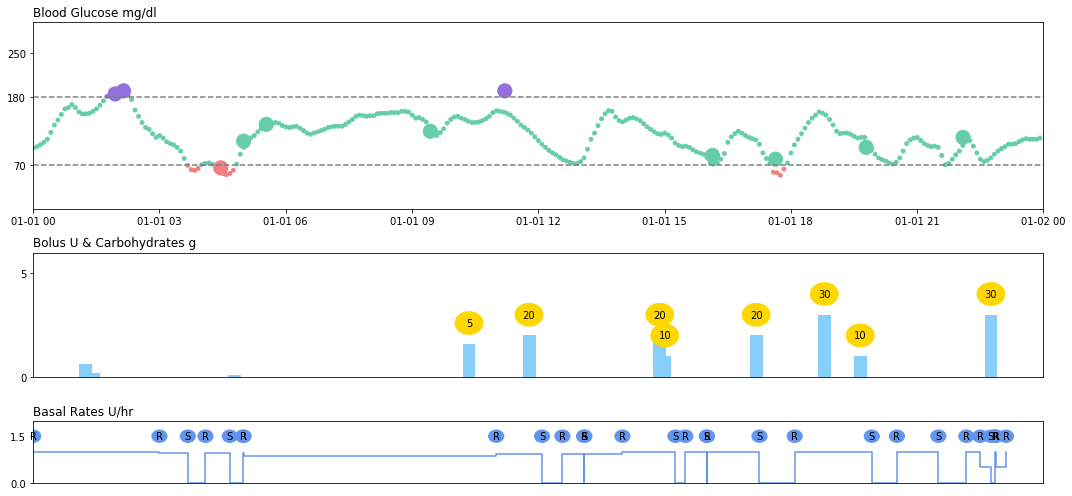

In [179]:
#Set fonts
rc('font',**{'family':'serif','serif':['Times']}) #Unclear if this is working, but should fix font sizes

#### Set the overall plot features ###
matplot_daily_fig, (ax1, ax2, ax3) = plt.subplots(nrows = 3, ncols = 1, figsize=(15, 7), gridspec_kw={'height_ratios': [3, 2, 1]})


###### Figure 1: Blood Glucose Levels ###### 
ax1.set_title('Blood Glucose mg/dl', loc = "left")
ax1.set_ylim([0,300])
ax1.scatter(x=cbg_ts["datetime_time"], y=cbg_ts["value_mgdl"], c=cbg_ts.bg_colors, s=15)
ax1.scatter(x=smbg_ts["datetime_time"], y=smbg_ts["value_mgdl"], marker='o', c=smbg_ts.bg_colors, s=200)
ax1.set_xlim(START_DATE, END_DATE)
ax1.axhline(HIGH_LIMIT,linestyle='dashed', color = "gray")
ax1.axhline(LOW_LIMIT,linestyle='dashed', color = "gray")
ax1.axes.get_yaxis().set_ticks([LOW_LIMIT, HIGH_LIMIT, URGENT_HIGH_LIMIT]) #Add y axis values


#ax1.axis('off') if want to remove the box around the graph
#ax1.axes.get_xaxis().set_ticks([]) #Hide x axis
#ax1.set_yticks(range(0, 300, 50)) #If want to adjust the tick marks with a range
#ax1.axvspan(0, (int(END_DATE.strftime('%Y%m%d'))-int(START_DATE.strftime('%Y%m%d')))/3, facecolor='lightgray', alpha=0.5) #Change background color


###### Figure 2: Bolus and Carbohydrates ######
ax2.set_title('Bolus U & Carbohydrates g', loc = "left")
ax2.bar(x=bolus_no_wizard_ts["datetime_time"], height=bolus_no_wizard_ts["normal"], color="lightskyblue", width=0.013) #Add bars for boluses
ax2.set_ylim([0, max(bolus_no_wizard["normal"])*2])
ax2.axes.get_xaxis().set_ticks([]) #Hide x axis
ax2.axes.get_yaxis().set_ticks([0,5]) #Add y axis values


#Create yellow circles with carb amounts (is there a more efficient way to do this, i.e. not with for loop)
index = 0
for element in bolus_wizard_ts["carbInput"]:
  if bolus_wizard_ts.iloc[index]["carbInput"] > 0:
    circle = mpatches.Ellipse((bolus_wizard_ts.iloc[index]["datetime_time"], (bolus_no_wizard_ts.iloc[index]["normal"])+1), 0.028, 1.1, color='gold')
    ax2.add_artist(circle)
    ax2.text(bolus_wizard_ts.iloc[index]["datetime_time"], 
             (bolus_no_wizard_ts.iloc[index]["normal"])+1, 
             int(bolus_wizard_ts.iloc[index]["carbInput"]), 
             horizontalalignment='center', verticalalignment='center')
  index+=1

###### Figure 3: Basal Rates ######
ax3.set_title('Basal Rates U/hr', loc = "left")
ax3.step(x = basal_ts["datetime_time"], y = basal_ts["rate"], color = "cornflowerblue")
ax3.set_xlim([START_DATE,END_DATE])
ax3.set_ylim([0,2])
ax3.axes.get_xaxis().set_ticks([]) #Hide x axis
ax3.axes.get_yaxis().set_ticks([0,1.5]) #Add y axis values


#Create blue circles with label 
index = 0
for element in basal_ts["datetime_time"]:
    circle = mpatches.Ellipse((basal_ts.iloc[index]["datetime_time"], 1.5), 0.015, .4, color='cornflowerblue')
    ax3.add_artist(circle)
    ax3.text(basal_ts.iloc[index]["datetime_time"], 
             1.5, 
             basal_ts.iloc[index]["label"], 
             horizontalalignment='center', verticalalignment='center')
    index+=1
   
matplot_daily_fig.tight_layout()

#### Save figure to google drive - uncomment to us ####
# Can update the type of file and resolution here

#from google.colab import drive
#drive.mount("drive", force_remount=True)

#matplot_daily_fig.savefig('daily_visualizations_matplotlib.png', dpi=300)
#!cp daily_visualizations_matplotlib.png drive/My\ Drive/


In [120]:
bolus_no_wizard_ts

,datetime_time,carbInput,normal
5966,2019-01-01 23:49:44,NaN,3.0
6019,2019-01-01 20:40:11,NaN,1.0
6034,2019-01-01 19:48:11,NaN,3.0
6058,2019-01-01 18:09:14,NaN,2.0
6095,2019-01-01 15:56:42,NaN,1.0
6099,2019-01-01 15:49:29,NaN,2.0
6146,2019-01-01 12:39:57,NaN,2.0
6168,2019-01-01 11:12:50,NaN,1.6
6242,2019-01-01 05:32:12,NaN,0.1
6298,2019-01-01 02:08:40,NaN,0.2


In [0]:
#Add the interaction

# Additional Metrics
# Time in Range 
# Average Glucose
# Bolus Insulin
# Time in Automode
# Total Carbs
# Standard Deviation
# CV (CGM)

##Plotly Versions

In [0]:
## Plotly Set-up Function ##
# Pulled this set-up code from Ed's Calculate your Effective Basal Rates Notebook
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-1.5.1.min.js?noext',
            },
          });
        </script>
        '''))

In [180]:
#### Plotly Setup ####
  
configure_plotly_browser_state()
init_notebook_mode(connected=True)



###### Figure 1: Blood Glucose Levels ###### 


## Set-up Layout
bg_layout = go.Layout(
   title=go.layout.Title(
        text='Blood Glucose (mg/dl)',
        x=0
    ),
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=50,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2
    ),
    xaxis=dict(
        range = (START_DATE, END_DATE)
    ),
    shapes = [
      {'type': 'line',
        'x0': START_DATE,
        'y0': LOW_LIMIT,
        'y1': LOW_LIMIT,
        'x1': END_DATE,
        'line': {
          'color': 'white',
          'width': 2,
          'dash': 'dash',
        },
      },
      {'type': 'line',
        'x0': START_DATE,
        'y0': HIGH_LIMIT,
        'y1': HIGH_LIMIT,
        'x1': END_DATE,
        'line': {
          'color': 'white',
          'width': 4,
          'dash': 'dash',
        },
      }
    ],
    margin=dict(
        l=40,
        r=30,
        b=50,
        t=50,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False,
    height=350
)


## Set-up Traces


#CBG Data
cbg_trace = go.Scatter(
    x = cbg_ts["datetime_time"], 
    y = cbg_ts["value_mgdl"],
    mode = 'markers',
    marker=dict(size=6,
      line=dict(width=0),
      color= cbg_ts["bg_colors"]
    )
    #,text = ["Text A", "Text B", "Text C", "Text D", "Text E"],
    #hoverinfo = 'text',
)

#SBG Data
smbg_trace=go.Scatter(
    x=smbg_ts["datetime_time"], 
    y=smbg_ts["value_mgdl"],
    mode='markers',
    marker=dict(size=16,
      line=dict(width=0),
      color=smbg_ts["bg_colors"]
    )
)

#Create and plot figure
bg_fig = go.Figure(data= [cbg_trace, smbg_trace], layout=bg_layout)
iplot(bg_fig)


###### Figure 2: Bolus and Carbohydrates ######


## Set-up Layout
bolus_layout = go.Layout(
    title=go.layout.Title(
        text='Bolus U and Carbohydrates g',
        x=0
    ),
    yaxis=dict(
        range=[0, 10], #autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=5,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
    ),
    xaxis=dict(
        range = (START_DATE, END_DATE)
    ),
    margin=dict(
        l=40,
        r=30,
        b=50,
        t=50,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False,
    height=250
)


#Bolus data
bolus_trace=go.Bar(
            x=bolus_no_wizard_ts["datetime_time"],
            y=bolus_no_wizard_ts["normal"],
            width=999999,
            marker=dict(
                color='lightskyblue'
            )
)


#Carb circles
carb_trace=go.Scatter(
              mode = 'markers + text',
              x=bolus_no_wizard_ts["datetime_time"],
              y=bolus_no_wizard_ts["normal"]+1,
              marker = dict(
                color = 'gold',
                size = 25
              ),
              showlegend = False,
              text=bolus_wizard_ts["carbInput"], 
              textposition='middle center'
  )

#Create and plot figure
bolus_fig = go.Figure(data= [bolus_trace, carb_trace], layout=bolus_layout)
iplot(bolus_fig)


###### Figure 3: Basal Rates ######


## Set-up Layout
basal_layout = go.Layout(
    title=go.layout.Title(
        text='Basal Rates U/hr',
        x=0
    ),
    xaxis=dict(
        range = (START_DATE, END_DATE)
    ),
    yaxis=dict(
        range=[0, 2], #autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=1,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2,
        #tickmode = 'linear',
        #tick0 = 0.5,
    ),
    margin=dict(
        l=40,
        r=30,
        b=50,
        t=50,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False,
    height=200
)


#Basal
basal_trace=go.Scatter(
              mode = 'lines',
              x=basal_ts["datetime_time"],
              y= basal_ts["rate"],
              showlegend = False,
              line=dict(
                  shape='vh',
                  color='cornflowerblue'
              ),
            fill='tonexty'
  )

annotation_trace=go.Bar(
              x=basal_ts["datetime_time"],
              y= [1.5] * basal_ts["datetime_time"].count(),
              showlegend = False,
              marker=dict(
                color='cornflowerblue',
                line=dict(
                    color='cornflowerblue',
                    width=2),
              )
  )

#Label circles
label_trace=go.Scatter(
              mode = 'markers + text',
              x=basal_ts["datetime_time"],
              y= [1.5] * basal_ts["datetime_time"].count(),
              marker = dict(
                color = 'cornflowerblue',
                size = 25
              ),
              showlegend = False,
              text=basal_ts['label'],
              textposition='middle center'
  )




#Create and plot figure
plotly_daily_fig = go.Figure(data= [basal_trace, annotation_trace, label_trace], layout=basal_layout)
iplot(plotly_daily_fig)

#Can export the images as png using the camera icon at upper right hand corner"Download plot as png"



In [124]:
#### Additional Constants ####

NUMBER_WEEKS = 1 #ENTER THIS - Choose from 1, 2 or 4
TIME_FRAME_HOURS = 6 # ENTER THIS - Choose 3, 6, 12, 24
#Note: 3 and 6 hours start at midnight, 12 and 24 start 

TIME_DELTA = timedelta(days = NUMBER_WEEKS*7 , hours = 0, minutes = 0, seconds = 0)
TREND_END_DATE = START_DATE+TIME_DELTA

configure_plotly_browser_state()
init_notebook_mode(connected=True)

#### Trend Visualizations ####

###### Figure 1: Bar Graph ###### 

## Set-up Layout ##
bg_layout = go.Layout(
   title=go.layout.Title(
        text='Blood Glucose (mg/dl) Trends',
        x=0
    ),
    yaxis=dict(
        autorange=True,
        showgrid=True,
        zeroline=True,
        dtick=50,
        gridcolor='rgb(255, 255, 255)',
        gridwidth=1,
        zerolinecolor='rgb(255, 255, 255)',
        zerolinewidth=2
    ),
    xaxis=dict(
        range = (START_DATE, TREND_END_DATE)
    ),
    shapes = [
      {'type': 'line',
        'x0': START_DATE,
        'y0': LOW_LIMIT,
        'y1': LOW_LIMIT,
        'x1': TREND_END_DATE,
        'line': {
          'color': 'white',
          'width': 2,
          'dash': 'dash',
        },
      },
      {'type': 'line',
        'x0': START_DATE,
        'y0': HIGH_LIMIT,
        'y1': HIGH_LIMIT,
        'x1': TREND_END_DATE,
        'line': {
          'color': 'white',
          'width': 4,
          'dash': 'dash',
        },
      }
    ],
    margin=dict(
        l=40,
        r=30,
        b=50,
        t=50,
    ),
    paper_bgcolor='rgb(243, 243, 243)',
    plot_bgcolor='rgb(243, 243, 243)',
    showlegend=False,
    height=350
)

## Set-up Traces ##

#If the time frame hours are 3 or 6, want to start at midnight, else start at 6am
if (TIME_FRAME_HOURS == 3) | (TIME_FRAME_HOURS == 6):
  range_start_date = START_DATE
else:
  range_start_date = START_DATE + timedelta(days = 0, hours = 6, minutes = 0, seconds = 0)

range_end_date = range_start_date + timedelta(days = 0, hours = TIME_FRAME_HOURS, minutes = 0, seconds = 0)

#Create an initial empty set of traces 
traces = []

#Iterate through each time chunk and add boxplot trace for that time chunk
for _ in range(int(24/TIME_FRAME_HOURS)):
  cbg_filtered = cbg_ts[(cbg_ts.datetime_time >= range_start_date) & (cbg_ts.datetime_time < range_end_date)]
  trace = go.Box(
      y=cbg_filtered["value_mgdl"],
      name = range_end_date.hour,
      marker = dict(
        color = 'mediumaquamarine'
      )
  )
  traces.append(trace)
  range_start_date = range_end_date
  range_end_date = range_end_date + timedelta(days = 0, hours = TIME_FRAME_HOURS, minutes = 0, seconds = 0)

#Create and plot figure
bg_trend_fig = go.Figure(data= traces, layout=bg_layout)
iplot(bg_trend_fig)


# To do:
# 
